# Figure 3: spatial correlations between bias
conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
# seasons = ['Annual', 'DJFMA', 'JJAS']
seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

list_vars = ['tas', 'snc', 'pr']
table = [None]*len(list_vars); label = [None]*len(list_vars); units = [None]*len(list_vars); 
cmap = [None]*len(list_vars); levels = [None]*len(list_vars)
for i, var in enumerate(list_vars):
    table[i] = u.get_table(var)
#     label[i], units[i], cmap[i], levels[i] = u.get_var_infos(var)
    label[i], units[i], cmap[i], levels[i], extend, \
        levels_diff, cmap_diff, extend_diff, \
        levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

# With APHRODITE

## Load results

In [31]:
# mmm: multimodel mean (is at the last index)
# It is removed here .isel(model=slice(0,-1))

bias = [None]*len(list_vars)
for i, var in enumerate(list_vars):
    bias[i] = xr.open_dataarray(
        'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
    ).isel(model=slice(0,-1))
    bias[i].name = var

## Create DataFrame to save correlation results

In [32]:
corr_labels = [
    'tas normalized bias',
    'tas bias / snc bias', 'tas bias / pr bias', 'snc bias / pr bias', 
    'tas bias / elevation', 'snc bias / elevation', 'pr bias / elevation'
]
index_corr = np.array(corr_labels*len(seasons))
index_seasons = np.array([[season]*len(corr_labels) for season in seasons]).flatten()

indexes = [index_seasons, index_corr]

temp = np.empty((indexes[0].size, bias[0].model.size))
temp[:] = np.nan

df = pd.DataFrame(temp, index = indexes, columns = bias[0].model.values)
df

BCC-CSM2-MR  BCC-ESM1  CAS-ESM2-0  CESM2  \
Annual tas normalized bias           NaN       NaN         NaN    NaN   
       tas bias / snc bias           NaN       NaN         NaN    NaN   
       tas bias / pr bias            NaN       NaN         NaN    NaN   
       snc bias / pr bias            NaN       NaN         NaN    NaN   
       tas bias / elevation          NaN       NaN         NaN    NaN   
       snc bias / elevation          NaN       NaN         NaN    NaN   
       pr bias / elevation           NaN       NaN         NaN    NaN   

                             CESM2-FV2  CESM2-WACCM  CESM2-WACCM-FV2  \
Annual tas normalized bias         NaN          NaN              NaN   
       tas bias / snc bias         NaN          NaN              NaN   
       tas bias / pr bias          NaN          NaN              NaN   
       snc bias / pr bias          NaN          NaN              NaN   
       tas bias / elevation        NaN          NaN              NaN   
       snc bias / elevation        NaN          NaN              NaN   
       pr bias / elevation         NaN          NaN              NaN   

                             CNRM-CM6-1  CNRM-CM6-1-HR  CNRM-ESM2-1  ...  \
Annual tas normalized bias          NaN            NaN          NaN  ...   
       tas bias / snc bias          NaN            NaN          NaN  ...   
       tas bias / pr bias           NaN            NaN          NaN  ...   
       snc bias / pr bias           NaN            NaN          NaN  ...   
       tas bias / elevation         NaN            NaN          NaN  ...   
       snc bias / elevation         NaN            NaN          NaN  ...   
       pr bias / elevation          NaN            NaN          NaN  ...   

                             IPSL-CM6A-LR  MIROC-ES2L  MIROC6  MPI-ESM1-2-HR  \
Annual tas normalized bias            NaN         NaN     NaN            NaN   
       tas bias / snc bias            NaN         NaN     NaN            NaN   
       tas bias / pr bias             NaN         NaN     NaN            NaN   
       snc bias / pr bias             NaN         NaN     NaN            NaN   
       tas bias / elevation           NaN         NaN     NaN            NaN   
       snc bias / elevation           NaN         NaN     NaN            NaN   
       pr bias / elevation            NaN         NaN     NaN            NaN   

                             MPI-ESM1-2-LR  MRI-ESM2-0  NorESM2-LM  \
Annual tas normalized bias             NaN         NaN         NaN   
       tas bias / snc bias             NaN         NaN         NaN   
       tas bias / pr bias              NaN         NaN         NaN   
       snc bias / pr bias              NaN         NaN         NaN   
       tas bias / elevation            NaN         NaN         NaN   
       snc bias / elevation            NaN         NaN         NaN   
       pr bias / elevation             NaN         NaN         NaN   

                             SAM0-UNICON  TaiESM1  UKESM1-0-LL  
Annual tas normalized bias           NaN      NaN          NaN  
       tas bias / snc bias           NaN      NaN          NaN  
       tas bias / pr bias            NaN      NaN          NaN  
       snc bias / pr bias            NaN      NaN          NaN  
       tas bias / elevation          NaN      NaN          NaN  
       snc bias / elevation          NaN      NaN          NaN  
       pr bias / elevation           NaN      NaN          NaN  

[7 rows x 27 columns]

In [33]:
df_pvalue = df.copy()

## Compute correlations

In [34]:
list_vars

['tas', 'snc', 'pr']

In [35]:
corr_labels

['tas normalized bias',
 'tas bias / snc bias',
 'tas bias / pr bias',
 'snc bias / pr bias',
 'tas bias / elevation',
 'snc bias / elevation',
 'pr bias / elevation']

In [36]:
# 0: tas
# 1: snc
# 2: pr
# 3: elevation

pairs = [[0, 0], [0, 1], [0, 2], [1, 2], [0, 3], [1, 3], [2, 3]]

In [37]:
%%time

for season in seasons:
# for season in ['Annual']:
    print(season)
    
    # To normalize tas bias 
    tas_max = abs(u.spatial_average(bias[0].sel(season=season).where(elevation > 2500))).max().values.item(0)
    
    for k, pair in enumerate(pairs):
        print(k)
        for model in bias[0].model.values:
#             print(model)
            
            if pair[1] == 0:
                df.loc[season, corr_labels[k]][model] = u.spatial_average(bias[0].sel(season=season, model=model).where(elevation > 2500)).values.item(0) / tas_max
                df_pvalue.loc[season, corr_labels[k]][model] = np.NaN
            else:
                # Get all values for HMA (>2500m) and flatten the values
                x = bias[pair[0]].sel(season=season, model=model).where(elevation > 2500).values.flatten()

                if pair[1] == 3:
                    y = elevation.sel(lat=latlim, lon=lonlim).where(elevation > 2500).values.flatten()
                else:
                    y = bias[pair[1]].sel(season=season, model=model).where(elevation > 2500).values.flatten()

                # Remove the nans
    #             print(len(x))
    #             print(len(y))
                if len(x) <= len(y):
                    temp = x
                else:
                    temp = y
                x = x[~np.isnan(temp)]
                y = y[~np.isnan(temp)]

                # Get rvalue
                df.loc[season, corr_labels[k]][model] = stats.linregress(x, y).rvalue
                df_pvalue.loc[season, corr_labels[k]][model] = stats.linregress(x, y).pvalue

Annual
0
1
2
3
4
5
6
CPU times: user 1.88 s, sys: 999 µs, total: 1.88 s
Wall time: 1.99 s


## Heatmap

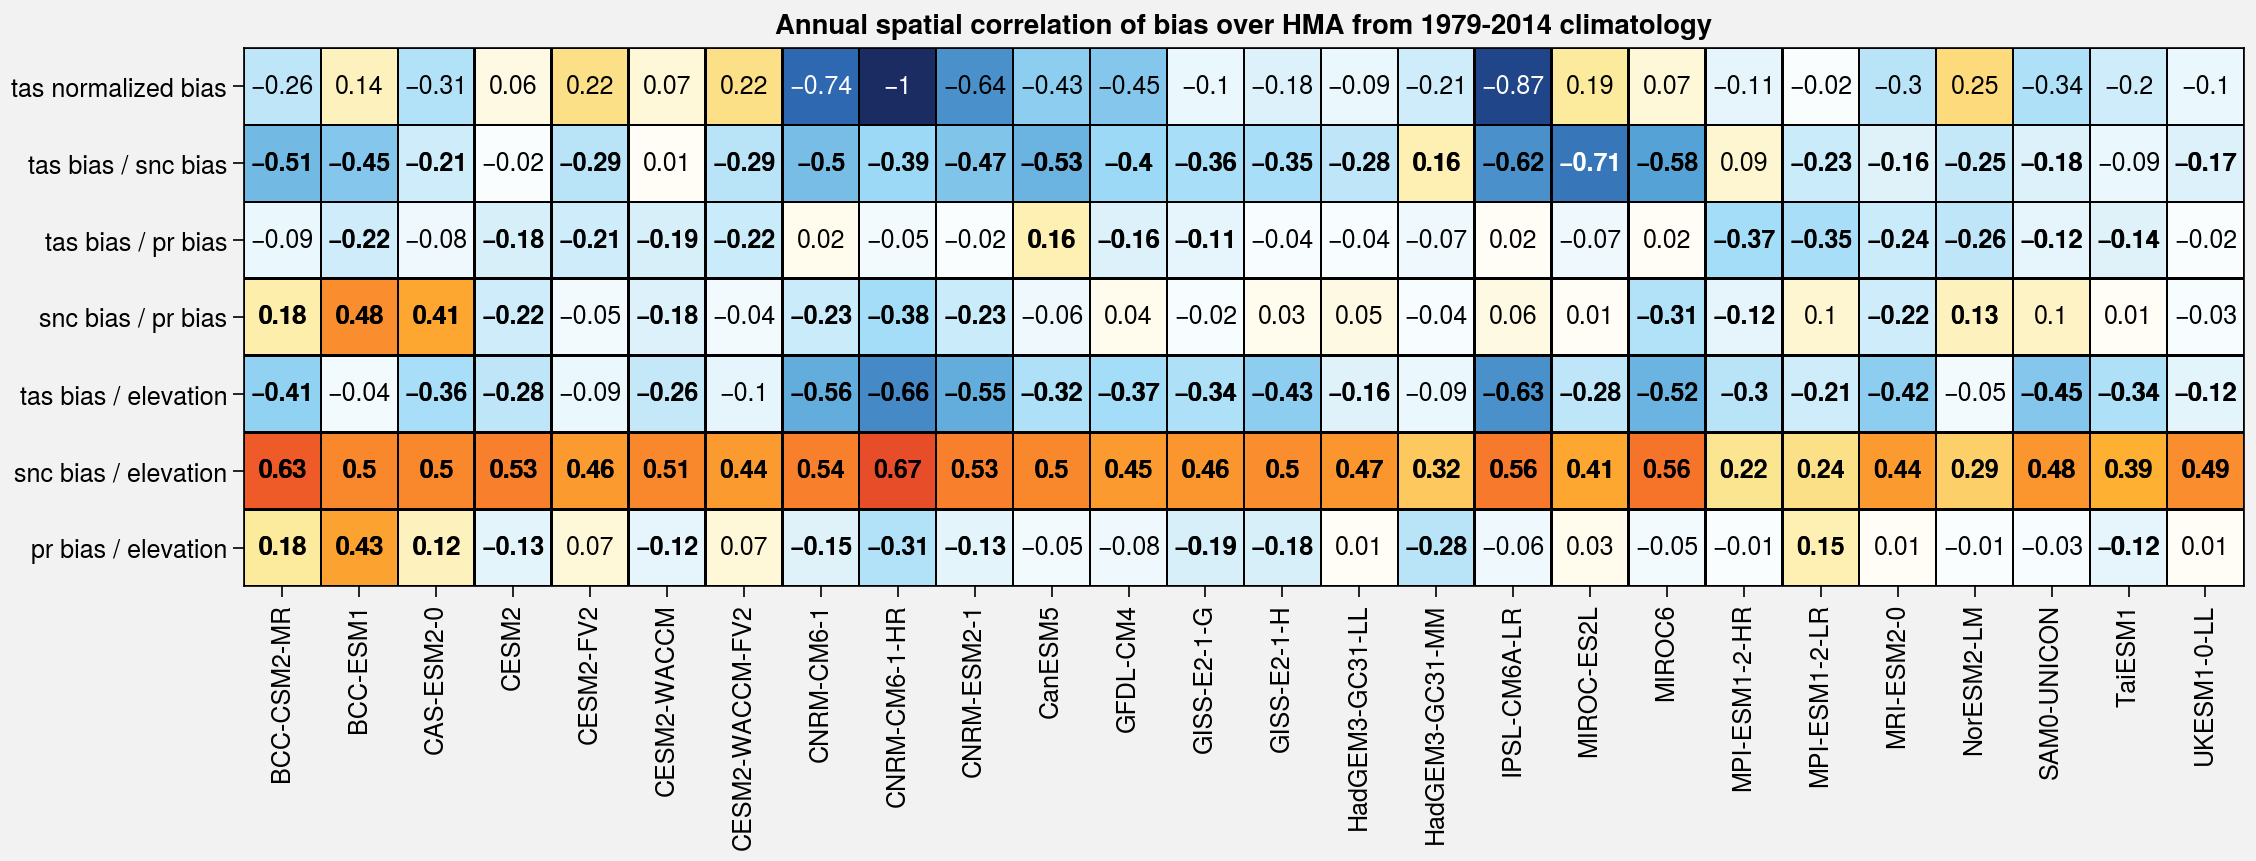

In [38]:
fig, axs = plot.subplots(nrows=len(seasons), ncols=1, axwidth=10)

for i, ax in enumerate(axs):
    
    ax.heatmap(
        df.loc[seasons[i]].drop(columns='CanESM5-CanOE'), 
#         df.loc[seasons[i]].where(df_pvalue.loc[seasons[i]] < 0.05), 
        cmap='ColdHot', vmin=-1, vmax=1, N=100,
        lw=0.5, edgecolor='k', labels=True
    )
    
    ax.heatmap(
        df.loc[seasons[i]].where(df_pvalue.loc[seasons[0]] < 0.05).drop(columns='CanESM5-CanOE'), 
#         df.loc[seasons[i]].where(df_pvalue.loc[seasons[i]] < 0.05), 
        cmap='ColdHot', vmin=-1, vmax=1, N=100,
        lw=0.5, edgecolor='k', labels=True, labels_kw={'weight': 'bold'}
    )
    

axs.format(
    xrotation=90, yreverse=True,
    suptitle='Annual spatial correlation of bias over HMA from '+period.start+'-'+period.stop+' climatology', 
#     ticklabelsize=10, suptitlesize=11, title=' '
)

filename = 'fig3_correlations_'+period.start+'-'+period.stop
fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')

## Redo with GPCP

## Load results

In [19]:
# mmm: multimodel mean (is at the last index)
# It is removed here .isel(model=slice(0,-1))

bias = [None]*len(list_vars)
for i, var in enumerate(list_vars):
    if var == 'pr':
        bias[i] = xr.open_dataarray(
            'results/'+var+'_GPCP_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
        ).isel(model=slice(0,-1))
    else:
        bias[i] = xr.open_dataarray(
            'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
        ).isel(model=slice(0,-1))
    bias[i].name = var

## Create DataFrame to save correlation results

In [20]:
corr_labels = [
    'tas normalized bias',
    'tas bias / snc bias', 'tas bias / pr bias', 'snc bias / pr bias', 
    'tas bias / elevation', 'snc bias / elevation', 'pr bias / elevation'
]
index_corr = np.array(corr_labels*len(seasons))
index_seasons = np.array([[season]*len(corr_labels) for season in seasons]).flatten()

indexes = [index_seasons, index_corr]

temp = np.empty((indexes[0].size, bias[0].model.size))
temp[:] = np.nan

df = pd.DataFrame(temp, index = indexes, columns = bias[0].model.values)
df

BCC-CSM2-MR  BCC-ESM1  CAS-ESM2-0  CESM2  \
Annual tas normalized bias           NaN       NaN         NaN    NaN   
       tas bias / snc bias           NaN       NaN         NaN    NaN   
       tas bias / pr bias            NaN       NaN         NaN    NaN   
       snc bias / pr bias            NaN       NaN         NaN    NaN   
       tas bias / elevation          NaN       NaN         NaN    NaN   
       snc bias / elevation          NaN       NaN         NaN    NaN   
       pr bias / elevation           NaN       NaN         NaN    NaN   

                             CESM2-FV2  CESM2-WACCM  CESM2-WACCM-FV2  \
Annual tas normalized bias         NaN          NaN              NaN   
       tas bias / snc bias         NaN          NaN              NaN   
       tas bias / pr bias          NaN          NaN              NaN   
       snc bias / pr bias          NaN          NaN              NaN   
       tas bias / elevation        NaN          NaN              NaN   
       snc bias / elevation        NaN          NaN              NaN   
       pr bias / elevation         NaN          NaN              NaN   

                             CNRM-CM6-1  CNRM-CM6-1-HR  CNRM-ESM2-1  ...  \
Annual tas normalized bias          NaN            NaN          NaN  ...   
       tas bias / snc bias          NaN            NaN          NaN  ...   
       tas bias / pr bias           NaN            NaN          NaN  ...   
       snc bias / pr bias           NaN            NaN          NaN  ...   
       tas bias / elevation         NaN            NaN          NaN  ...   
       snc bias / elevation         NaN            NaN          NaN  ...   
       pr bias / elevation          NaN            NaN          NaN  ...   

                             IPSL-CM6A-LR  MIROC-ES2L  MIROC6  MPI-ESM1-2-HR  \
Annual tas normalized bias            NaN         NaN     NaN            NaN   
       tas bias / snc bias            NaN         NaN     NaN            NaN   
       tas bias / pr bias             NaN         NaN     NaN            NaN   
       snc bias / pr bias             NaN         NaN     NaN            NaN   
       tas bias / elevation           NaN         NaN     NaN            NaN   
       snc bias / elevation           NaN         NaN     NaN            NaN   
       pr bias / elevation            NaN         NaN     NaN            NaN   

                             MPI-ESM1-2-LR  MRI-ESM2-0  NorESM2-LM  \
Annual tas normalized bias             NaN         NaN         NaN   
       tas bias / snc bias             NaN         NaN         NaN   
       tas bias / pr bias              NaN         NaN         NaN   
       snc bias / pr bias              NaN         NaN         NaN   
       tas bias / elevation            NaN         NaN         NaN   
       snc bias / elevation            NaN         NaN         NaN   
       pr bias / elevation             NaN         NaN         NaN   

                             SAM0-UNICON  TaiESM1  UKESM1-0-LL  
Annual tas normalized bias           NaN      NaN          NaN  
       tas bias / snc bias           NaN      NaN          NaN  
       tas bias / pr bias            NaN      NaN          NaN  
       snc bias / pr bias            NaN      NaN          NaN  
       tas bias / elevation          NaN      NaN          NaN  
       snc bias / elevation          NaN      NaN          NaN  
       pr bias / elevation           NaN      NaN          NaN  

[7 rows x 27 columns]

In [21]:
df_pvalue = df.copy()

## Compute correlations

In [22]:
list_vars

['tas', 'snc', 'pr']

In [23]:
corr_labels

['tas normalized bias',
 'tas bias / snc bias',
 'tas bias / pr bias',
 'snc bias / pr bias',
 'tas bias / elevation',
 'snc bias / elevation',
 'pr bias / elevation']

In [24]:
# 0: tas
# 1: snc
# 2: pr
# 3: elevation

pairs = [[0, 0], [0, 1], [0, 2], [1, 2], [0, 3], [1, 3], [2, 3]]

In [25]:
%%time

for season in seasons:
# for season in ['Annual']:
    print(season)
    
    # To normalize tas bias 
    tas_max = abs(u.spatial_average(bias[0].sel(season=season).where(elevation > 2500))).max().values.item(0)
    
    for k, pair in enumerate(pairs):
        print(k)
        for model in bias[0].model.values:
#             print(model)
            
            if pair[1] == 0:
                df.loc[season, corr_labels[k]][model] = u.spatial_average(bias[0].sel(season=season, model=model).where(elevation > 2500)).values.item(0) / tas_max
                df_pvalue.loc[season, corr_labels[k]][model] = np.NaN
            else:
                # Get all values for HMA (>2500m) and flatten the values
                x = bias[pair[0]].sel(season=season, model=model).where(elevation > 2500).values.flatten()

                if pair[1] == 3:
                    y = elevation.sel(lat=latlim, lon=lonlim).where(elevation > 2500).values.flatten()
                else:
                    y = bias[pair[1]].sel(season=season, model=model).where(elevation > 2500).values.flatten()

                # Remove the nans
    #             print(len(x))
    #             print(len(y))
                if len(x) <= len(y):
                    temp = x
                else:
                    temp = y
                x = x[~np.isnan(temp)]
                y = y[~np.isnan(temp)]

                # Get rvalue
                df.loc[season, corr_labels[k]][model] = stats.linregress(x, y).rvalue
                df_pvalue.loc[season, corr_labels[k]][model] = stats.linregress(x, y).pvalue

Annual
0
1
2
3
4
5
6
CPU times: user 2.71 s, sys: 3 ms, total: 2.72 s
Wall time: 3.08 s


## Heatmap

In [26]:
df.loc[seasons[0]].where(df_pvalue.loc[seasons[0]] < 0.05)

,BCC-CSM2-MR,BCC-ESM1,CAS-ESM2-0,CESM2,CESM2-FV2,CESM2-WACCM,CESM2-WACCM-FV2,CNRM-CM6-1,CNRM-CM6-1-HR,CNRM-ESM2-1,...,IPSL-CM6A-LR,MIROC-ES2L,MIROC6,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NorESM2-LM,SAM0-UNICON,TaiESM1,UKESM1-0-LL
tas normalized bias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tas bias / snc bias,-0.509306,-0.451413,-0.213905,NaN,-0.289626,NaN,-0.288434,-0.496266,-0.385337,-0.466305,...,-0.620042,-0.711451,-0.582495,NaN,-0.229679,-0.158353,-0.248985,-0.179375,NaN,-0.167999
tas bias / pr bias,NaN,-0.328251,NaN,NaN,-0.197086,NaN,-0.214417,NaN,NaN,NaN,...,NaN,-0.122822,0.150813,-0.242079,-0.316743,NaN,-0.248704,NaN,NaN,NaN
snc bias / pr bias,0.209527,0.703382,0.451684,-0.219843,NaN,-0.180498,NaN,-0.256120,-0.364703,-0.248647,...,NaN,0.193858,-0.382024,NaN,0.148929,-0.229988,0.266478,0.130215,NaN,NaN
tas bias / elevation,-0.411882,NaN,-0.359465,-0.277273,NaN,-0.258303,NaN,-0.557848,-0.659390,-0.546357,...,-0.627965,-0.275412,-0.521695,-0.296656,-0.214361,-0.421959,NaN,-0.450938,-0.339001,-0.122377
snc bias / elevation,0.627230,0.500988,0.501300,0.529355,0.455385,0.512616,0.444179,0.535935,0.672503,0.534626,...,0.557652,0.412476,0.562797,0.217905,0.236524,0.443359,0.287884,0.476727,0.391622,0.489301
pr bias / elevation,NaN,0.374482,NaN,-0.274070,NaN,-0.261312,NaN,-0.322961,-0.440287,-0.295311,...,-0.220969,-0.146240,-0.203942,-0.157820,NaN,-0.168029,-0.169588,-0.151207,-0.199449,-0.153661


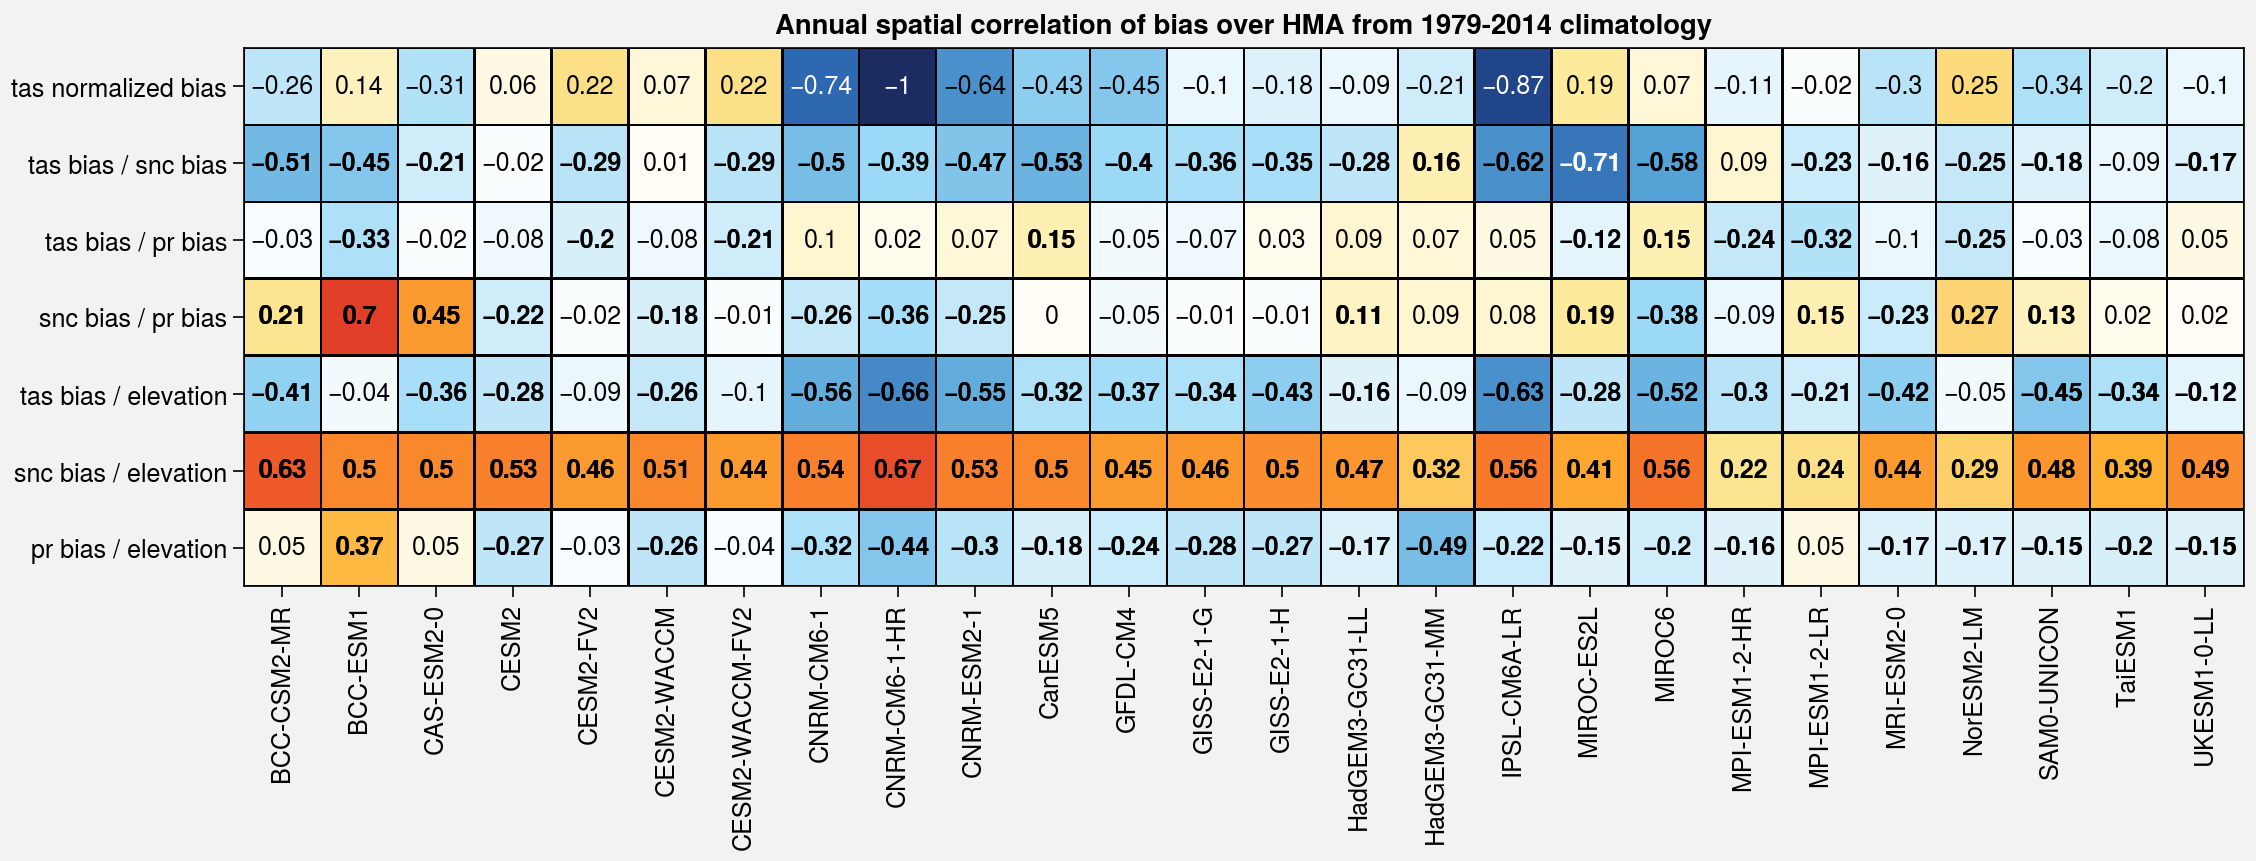

In [29]:
fig, axs = plot.subplots(nrows=len(seasons), ncols=1, axwidth=10)

for i, ax in enumerate(axs):
    
    ax.heatmap(
        df.loc[seasons[i]].drop(columns='CanESM5-CanOE'), 
#         df.loc[seasons[i]].where(df_pvalue.loc[seasons[i]] < 0.05), 
        cmap='ColdHot', vmin=-1, vmax=1, N=100,
        lw=0.5, edgecolor='k', labels=True
    )
    
    ax.heatmap(
        df.loc[seasons[i]].where(df_pvalue.loc[seasons[0]] < 0.05).drop(columns='CanESM5-CanOE'), 
#         df.loc[seasons[i]].where(df_pvalue.loc[seasons[i]] < 0.05), 
        cmap='ColdHot', vmin=-1, vmax=1, N=100,
        lw=0.5, edgecolor='k', labels=True, labels_kw={'weight': 'bold'}
    )
    

axs.format(
    xrotation=90, yreverse=True,
    suptitle='Annual spatial correlation of bias over HMA from '+period.start+'-'+period.stop+' climatology', 
#     ticklabelsize=10, suptitlesize=11, title=' '
)

filename = 'figS3_correlations_GPCP_'+period.start+'-'+period.stop
fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')